In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [15]:
df = pd.read_csv("../Data/daily_data.csv")
df.rename(columns={"Unnamed: 0": "datetime"}, inplace=True)
#df.set_index("datetime", inplace=True)
df["datetime"] = pd.to_datetime(df['datetime'])

df.set_index("datetime", inplace=True)

<AxesSubplot: xlabel='datetime'>

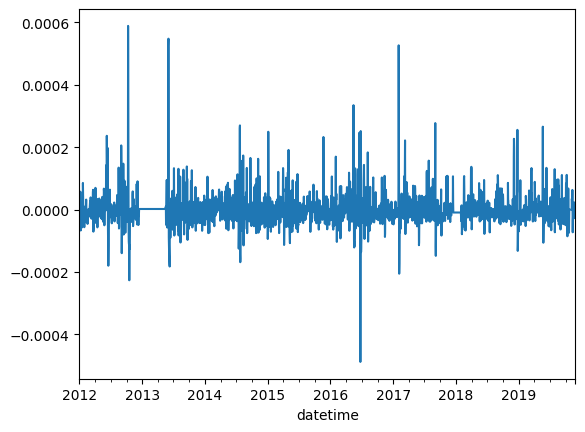

In [16]:
df["change_rate"].plot()

In [17]:
df1 = df[["water_level"]]
df_train = df1.loc[df1.index < "2018-11-27", ["water_level"]]
df_test = df1.loc[df1.index >= "2018-11-27", ["water_level"]]

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


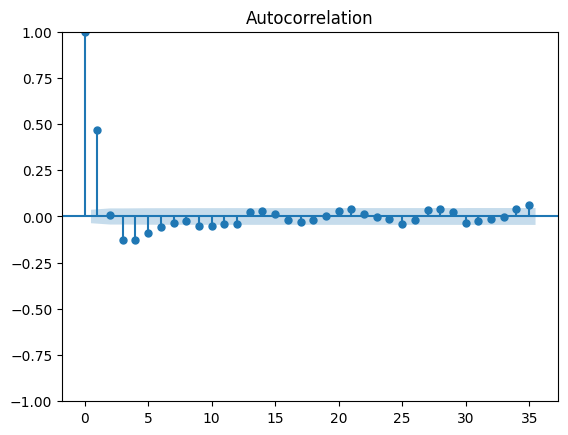

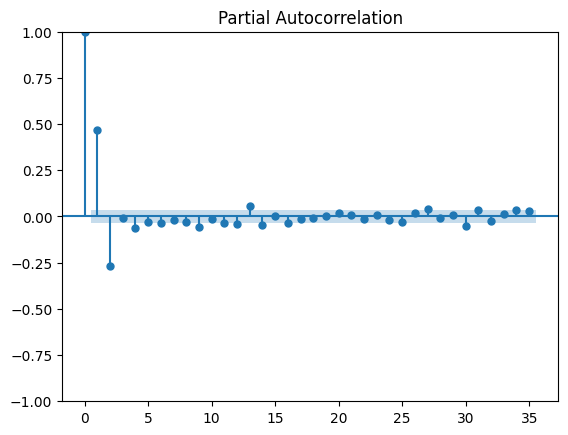

In [23]:
## autocorrelation change rate

# plot autocorrelation
acf_original = plot_acf(df["change_rate"].dropna())
# plot partial autocorrelation
pacf_original = plot_pacf(df["change_rate"].dropna()) # the low partial autocorrelation suggests that the time series is stationary

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


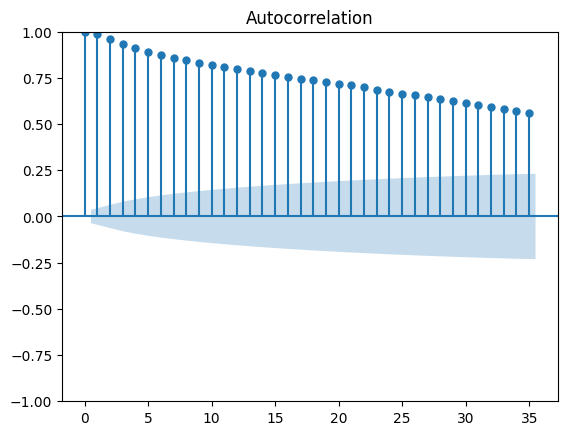

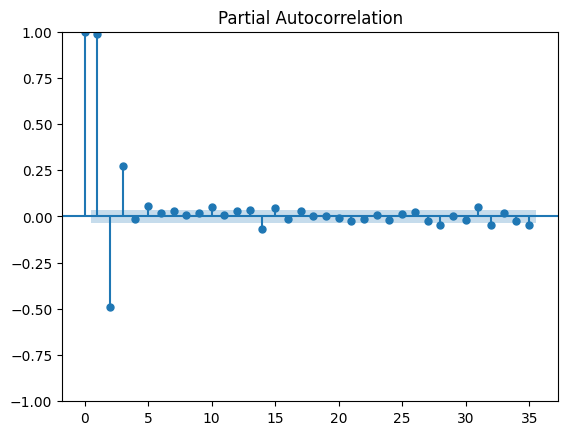

In [18]:
## autocorrelation water level

# plot autocorrelation 
acf_original = plot_acf(df["water_level"])
# plot partial autocorrelation
pacf_original = plot_pacf(df["water_level"]) # the autocorrelation of the 2. lag suggest that the series is NOT stationary

In [19]:
# ADF test for stationarity 
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df["water_level"])
print(f'p-value: {adf_test[1]}')

p-value: 0.00037745093165935653


In [21]:

adf_test = adfuller(df["change_rate"].dropna())
print(f'p-value: {adf_test[1]}')

p-value: 1.486791761516015e-29


<AxesSubplot: xlabel='datetime'>

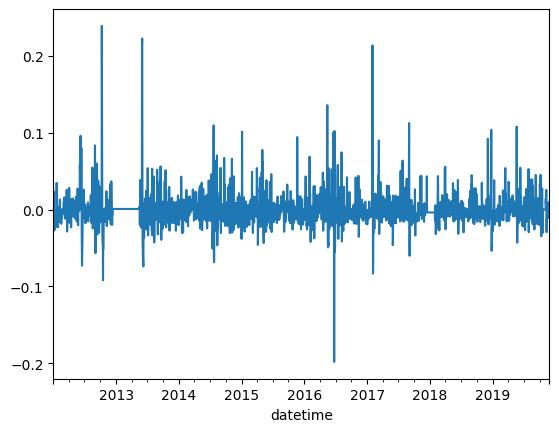

In [24]:
# make the water level series stationary
df_train_diff = df["water_level"].diff().dropna()
df_train_diff.plot()

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


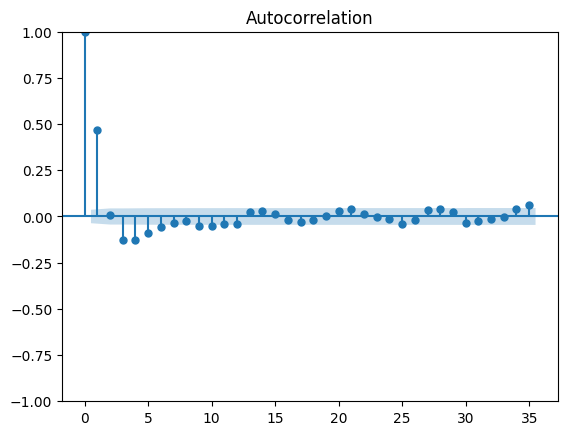

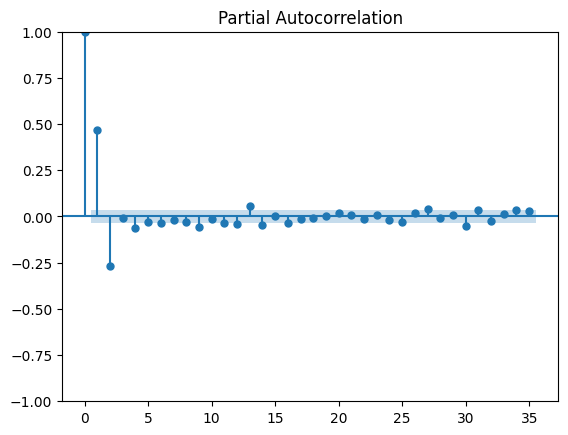

In [25]:
# plot autocorrelation and partial autocorrelation again for water level series after differencing to make series more stationary (lag 1 is not strongly autocorrelated anymore)
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [26]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            water_level   No. Observations:                 2522
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6621.979
Date:                Wed, 23 Nov 2022   AIC                         -13237.957
Time:                        17:24:47   BIC                         -13220.460
Sample:                    01-01-2012   HQIC                        -13231.608
                         - 11-26-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6015      0.008     71.637      0.000       0.585       0.618
ar.L2         -0.2773      0.012    -23.202      0.000      -0.301      -0.254
sigma2         0.0003   1.99e-06    153.823      0.0

In [31]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=True)
auto_arima

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [28]:
# auto creating model
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df1['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df1.plot()

NameError: name 'auto_arima' is not defined

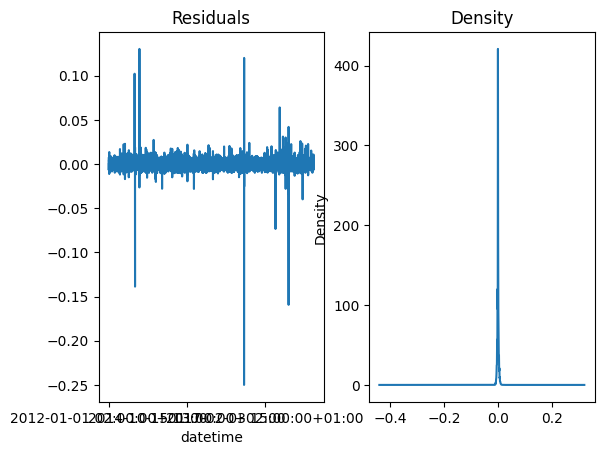

In [27]:
# plot residuals and their density
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

C:\Users\lucal\AppData\Local\Temp\ipykernel_27344\1765575725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['forecast_manual'] = [None]*len(df_train) + list(forecast_test)


<AxesSubplot: xlabel='datetime'>

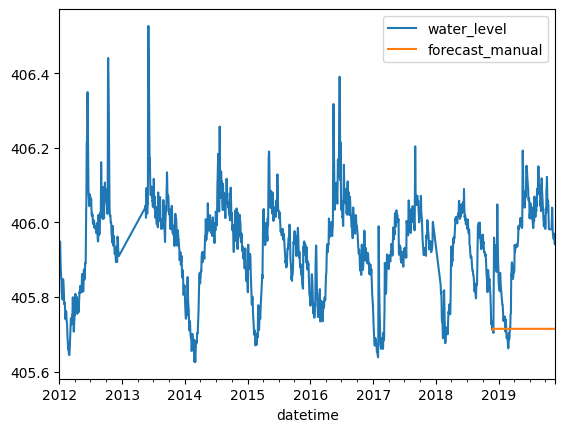

In [30]:
#predict with ARIMA model and plot the result
forecast_test = model_fit.forecast(len(df_test))

df1['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df1.plot()

In [29]:
df1

,water_level,forecast_manual
datetime,,
2012-01-01,405.911957,NaN
2012-01-02,405.913472,NaN
2012-01-03,405.923819,NaN
2012-01-04,405.926250,NaN
2012-01-05,405.925625,NaN
...,...,...
2019-11-23,405.948889,405.714864
2019-11-24,405.942014,405.714864
2019-11-25,405.941597,405.714864


In [36]:
df

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,precipitation (mm),dew_point,inflow_linth,outflow_limmat,evaporation,...,change_rate,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00+01:00,-0.645194,-0.531480,-0.427330,-1.195659,0.355152,-0.029140,-0.127692,-0.822761,0.839402,0.455744,...,0.000008,-1.438385,0.067534,-0.161685,0.162399,0.324536,0.207528,0.147714,1.208209,0.282431
2012-01-01 02:00:00+01:00,-0.638259,-0.523163,-0.427330,-1.195659,0.384346,-0.183537,-0.196180,-0.815353,1.036327,0.455773,...,0.000016,-1.459653,0.149064,-0.306180,0.062108,0.439888,0.214359,0.143550,1.256541,0.403222
2012-01-01 03:00:00+01:00,-0.631323,-0.514845,-0.405622,-1.195659,0.393329,-0.183537,-0.061837,-0.808530,1.352741,0.455851,...,0.000004,-1.379926,0.363382,-0.330767,0.058122,0.533071,0.251719,0.150467,1.468668,0.507375
2012-01-01 04:00:00+01:00,-0.624388,-0.514845,-0.405622,-1.195659,0.334941,-0.183537,-0.024959,-0.797608,1.499289,0.455915,...,0.000016,-1.354054,0.466648,-0.299939,0.010921,0.585337,0.256571,0.148907,1.545924,0.563727
2012-01-01 05:00:00+01:00,-0.610517,-0.506527,-0.394768,-1.195659,0.339432,-0.183537,-0.043398,-0.790062,1.445588,0.455980,...,0.000004,-1.347376,0.426341,-0.301094,0.015030,0.580665,0.248685,0.143167,1.510461,0.538862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-27 01:00:00+01:00,-0.348360,-0.284859,-0.132098,-0.567605,-2.184744,-0.183537,-0.309449,-0.401463,-0.434345,0.455680,...,0.000000,-0.710445,-0.394903,1.500231,-1.675796,-0.220554,0.070490,-0.059268,-0.026523,-0.130412
2019-11-27 02:00:00+01:00,-0.443721,-0.351817,-0.044179,-0.577418,-2.236395,-0.183537,-0.288376,-0.406425,-0.435537,0.455670,...,-0.000008,-0.741466,-0.378109,1.541225,-1.710344,-0.244596,0.198075,-0.112106,-0.013389,-0.154953
2019-11-27 03:00:00+01:00,-0.351828,-0.286938,-0.134811,-0.565152,-2.321732,-0.183537,-0.251498,-0.413213,-0.429849,0.455675,...,0.000016,-0.684203,-0.371364,1.598178,-1.769599,-0.259346,0.073310,-0.055505,0.006463,-0.138279


In [37]:
fig, ax=plt.subplots(figsize=(10,8))
ax.plot(df["water_level"])
plt.show()

KeyboardInterrupt: 

In [19]:
# For PCA, we want to standardize our data, i.e., de-mean it and divide it by the standard deviation
standardize = lambda x: (x - x.mean()) / x.std()
features = df.columns[:-3] # All sepal/petal length/width
df[features] = standardize(df[features])

In [22]:
# Column names for our principal components
principal_components = [f"PC{i+1}" for i in range(len(features))]

# Run PCA with 4 principal components on our iris data
pca = PCA(n_components=9)
df[principal_components] = pca.fit_transform(df[features])

In [23]:
fig = px.scatter_matrix(
    features,
    dimensions=range(9),
    )

ValueError: Value of 'dimensions_1' is not the name of a column in 'data_frame'. Expected one of [0] but received: 1

In [28]:
#df1 = px.data.df()
features = df[["suction_tension (20cm)", "water_temperature", "precipitation (mm)", "dew_point", "inflow_linth", "outflow_limmat"]]

pca = PCA()
#components = pca.fit_transform(df[features])
#labels = {
#    str(i): f"PC {i+1} ({var:.1f}%)"
#    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
#}

fig = px.scatter_matrix(
    features,
    dimensions=range(6),
    )
fig.update_traces(diagonal_visible=True)
fig.show()

ValueError: Value of 'dimensions_0' is not the name of a column in 'data_frame'. Expected one of ['suction_tension (20cm)', 'water_temperature', 'precipitation (mm)', 'dew_point', 'inflow_linth', 'outflow_limmat'] but received: 0

In [10]:
df

,datetime,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,precipitation (mm),dew_point,water_level,change_rate,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,2012-01-01 01:00:00+01:00,0.500,0.600,1.000,5.900000,972.333333,0.016667,6.833333,405.893333,0.000008,...,-26.336982,32.538556,1.910996,0.299199,7.382865,-1.008152,-4.490087,-0.028848,0.015634,-7.575587e-06
1,2012-01-01 02:00:00+01:00,0.600,0.700,1.000,5.900000,972.550000,0.000000,6.400000,405.900000,0.000016,...,-27.524452,36.851770,2.284572,0.235464,8.043431,-1.073867,-4.133554,-0.045594,0.010433,-1.600696e-05
2,2012-01-01 03:00:00+01:00,0.700,0.800,1.200,5.900000,972.616667,0.000000,7.250000,405.901667,0.000004,...,-29.210491,43.690344,2.316677,0.110820,10.073285,-1.121270,-4.663848,-0.051368,-0.004517,-3.698458e-06
3,2012-01-01 04:00:00+01:00,0.800,0.800,1.200,5.900000,972.183333,0.000000,7.483333,405.908333,0.000016,...,-29.954383,46.695649,2.076483,-0.324049,10.817145,-1.127352,-4.769184,-0.053954,-0.005768,-1.600633e-05
4,2012-01-01 05:00:00+01:00,1.000,0.900,1.300,5.900000,972.216667,0.000000,7.366667,405.910000,0.000004,...,-29.332959,45.460298,2.131173,-0.280027,10.385581,-1.058133,-4.711259,-0.052914,-0.001046,-3.674446e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60452,2019-11-27 01:00:00+01:00,4.780,3.565,3.720,10.166667,953.483333,0.000000,5.683333,405.950000,0.000000,...,-7.519153,-2.464144,-12.927130,-9.837070,-3.602378,1.078628,-0.374296,-0.039812,0.097853,8.338040e-07
60453,2019-11-27 02:00:00+01:00,3.405,2.760,4.530,10.100000,953.100000,0.000000,5.816667,405.946667,-0.000008,...,-8.571428,-2.760526,-13.974074,-9.197340,-3.553085,1.892167,-0.518845,-0.041166,0.096684,9.099571e-06
60454,2019-11-27 03:00:00+01:00,4.730,3.540,3.695,10.183333,952.466667,0.000000,6.050000,405.953333,0.000016,...,-7.637666,-2.180684,-13.773369,-10.484309,-3.346688,1.068664,-0.568203,-0.042354,0.101726,-1.551565e-05
60455,2019-11-27 04:00:00+01:00,4.810,3.585,3.635,10.150000,951.600000,0.000000,6.233333,405.948333,-0.000012,...,-7.636093,-2.001299,-14.413588,-11.105455,-3.272678,1.026405,-0.674923,-0.044166,0.097952,1.324273e-05
